# Pipeline

So far, we used Scikit-learn for its **ML estimators like the LinearRegression or Ridge ones and saw a few examples of transformers with the StandardScaler and PolynomialFeatures objects.** In this unit and the next ones, we will see **how to assemble Scikit-learn estimators and transformers into a full ML pipeline.**

In this unit, we will see how to use the Pipeline object from Scikit-learn using the bike sharing data.

In [1]:
import pandas as pd

data_df = pd.read_csv('bike-sharing.csv')
data_df.head()

,temp,hum,windspeed,yr,workingday,holiday,weekday,season,weathersit,casual
0,0.344,0.806,0.160,2011,no,no,6,spring,cloudy,331
1,0.363,0.696,0.249,2011,no,no,0,spring,cloudy,131
2,0.196,0.437,0.248,2011,yes,no,1,spring,clear,120
3,0.200,0.590,0.160,2011,yes,no,2,spring,clear,108
4,0.227,0.437,0.187,2011,yes,no,3,spring,clear,82


In [3]:
from sklearn.model_selection import train_test_split

# One-hot encoding
encoded_df = pd.get_dummies(data_df)

# Split into train/test sets
X = encoded_df.drop('casual', axis=1).values
y = data_df.casual.values
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)

In [5]:
from sklearn.preprocessing import StandardScaler

# Standardize data
scaler = StandardScaler()
X_tr_rescaled = scaler.fit_transform(X_tr)
X_te_rescaled = scaler.transform(X_te)

In [8]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(X_tr_rescaled, y_tr)
print('MAE: {:.0f}'.format(MAE(y_te, ridge.predict(X_te_rescaled))))

MAE: 280


In [7]:
import numpy as np

median_predictions = np.full_like(y_te, np.median(y_tr))
print('Median baseline: {:.0f}'.format(MAE(y_te, median_predictions)))

Median baseline: 523


Applying different preprocessing steps to the train/test data is a common mistake which **can be hard to detect when we have a long sequence of transformations**. To solve this issue, we can **use the Pipeline object to encapsulate them with the estimator.** Let's see how to use this object.

### Pipeline Object

In [9]:
from sklearn.pipeline import Pipeline

# Create pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

The steps are simply (name, object) pairs. For each object, we can choose a name that we can then use later to refer to the step. In this case, we simply name the StandardScaler() step scaler and the Ridge() one ridge.

We can then retrieve the list of steps with **the named_steps** attribute.

In [10]:
# Get a dictionary with each step
pipe.named_steps

{'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'ridge': Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001)}

**The pipeline object can be used as a standard Scikit-learn estimator i.e. it implements the usual fit(), predict() and score() functions from the estimator API.**

In [11]:
# Fit on the train set
pipe.fit(X_tr, y_tr)

# Evaluate on the test set
print('MAE: {:.0f}'.format(MAE(y_te, pipe.predict(X_te))))

MAE: 280


### Multiple preprocessing steps

In the example above, we have a single preprocessing step. The pipe.fit() call is equivalent to applying the following handmade function

In [12]:
def pipe_fit(X, y):
    # Fit and apply the transformation
    X1 = scaler.fit_transform(X)

    # Fit the estimator
    ridge.fit(X1, y)

# Fit to the train data
pipe_fit(X_tr, y_tr)

In [13]:
def pipe_predict(X):
    # Apply the transformation
    X1 = scaler.transform(X)

    # Make predictions
    return ridge.predict(X1)

# Evaluate on the test set
print('MAE: {:.0f}'.format(MAE(y_te, pipe_predict(X_te))))

MAE: 280


In [14]:
# Pipeline with three transformations
# pipe = Pipeline([
#     ('transform1', ...),
#     ('transform2', ...),
#     ('transform3', ...),
#     ('estimator', ...)
# ])

### Optional steps
It can be interesting to try fitting an estimator with and without a preprocessing step to see if it improves to results. We will see a few scenarios in the next course where this is helpful. To achieve this, we can simply set the step to None

In [16]:
# Create a pipeline
pipe = Pipeline([
    ('scaler', None), # Disable this step
    ('ridge', Ridge())
])

# Fit pipeline to the train set
pipe.fit(X_tr, y_tr)

# Accuracy on the test set
print('MAE: {:.0f}'.format(MAE(y_te, pipe.predict(X_te))))

MAE: 282


### Grid search with pipelines
Let's see how we would tune the alpha hyperparameter using grid search on our pipeline

In [17]:
import numpy as np

# Variable to store the results
gs_results = []

# Grid search
for alpha in np.logspace(-4, 4, num=100):
    # Create/fit the pipeline
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(alpha))
    ])
    pipe.fit(X_tr, y_tr)

    # Save model and its performance on train/test sets
    gs_results.append({
        'alpha': alpha,
        'train_mae': MAE(y_tr, pipe.predict(X_tr)),
        'test_mae': MAE(y_te, pipe.predict(X_te)),
    })

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.head()

,alpha,test_mae,train_mae
0,0.000100,279.754483,262.057394
1,0.000120,279.754483,262.057392
2,0.000145,279.754485,262.057391
3,0.000175,279.754486,262.057389
4,0.000210,279.754487,262.057386


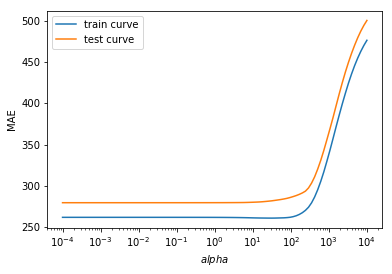

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the validation curves
plt.semilogx(gs_results['alpha'], gs_results['train_mae'], label='train curve')
plt.semilogx(gs_results['alpha'], gs_results['test_mae'], label='test curve')
plt.xlabel('$alpha$')
plt.ylabel('MAE')
plt.legend()
plt.show()

The model is not overfitting: the test curve remains flat when releasing the regularization constraint i.e. alpha values close to zero. On the other hand, we can see that the performance quickly drops when increasing alpha. This corresponds to the underfitting case.

If we don't want to create a new pipeline object in the for loop (ex. for readability), we can also use the **get_params() and set_params() functions** which are available in every Scikit-learn estimator including the Pipeline one.

In [19]:
# Create the pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])
pipe.get_params()

{'memory': None,
 'steps': [('scaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('ridge',
   Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001))],
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'ridge': Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'ridge__alpha': 1.0,
 'ridge__copy_X': True,
 'ridge__fit_intercept': True,
 'ridge__max_iter': None,
 'ridge__normalize': False,
 'ridge__random_state': None,
 'ridge__solver': 'auto',
 'ridge__tol': 0.001}

In this case, the dictionary of parameters from our pipe estimator contains all the steps with their hyperparameters prefixed by the name of the step and two underscores _. For instance, ridge__alpha corresponds to the regularization strength of the ridge step.

We can use the same syntax to set each hyperparameter value. For instance, let's set the alpha one in our grid-search loop.

In [2]:
# Variable to store the results
gs_results = []

# Grid search
for alpha in np.logspace(-4, 4, num=100):
    # Fit the pipeline
    pipe.set_params(ridge__alpha=alpha)
    pipe.fit(X_tr, y_tr)

    # Save model and its performance on train/test sets
    gs_results.append({
        'alpha': alpha,
        'train_mae': MAE(y_tr, pipe.predict(X_tr)),
        'test_mae': MAE(y_te, pipe.predict(X_te)),
    })

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)

# Plot the validation curves
plt.semilogx(gs_results['alpha'], gs_results['train_mae'], label='train curve')
plt.semilogx(gs_results['alpha'], gs_results['test_mae'], label='test curve')
plt.xlabel('$alpha$')
plt.ylabel('MAE')
plt.legend()
plt.show()

NameError: name 'np' is not defined

Both approaches are correct and produce the same results. However, the set_params() one can be useful to quickly test different hyperparameter values without having to define new pipeline objects.

### Summary
In this unit, we saw how to encapsulate a set of preprocessing steps and an estimator into a single Pipeline object. It's interesting to note that we included only the standardization step in the pipeline and not the one-hot encoding one which was performed outside Scikit-learn with the get_dummies() function from Pandas.

In the next unit, **we will see how to encode categorical variables directly in Scikit-learn.** To achieve this, **we will use the ColumnTransformer object which is part of a new workflow that tries to consolidate the data manipulation steps**, usually done in Pandas, with the modeling part from Scikit-learn.

# Column transformations

Perform the data preparation, exploratory data analysis (EDA), feature encoding/engineering, outliers removal in Pandas before the ML modeling as we have seen so far in this course. When the data is in a good format and ready for the ML models, convert the DataFrame to a Numpy 2d float array with .values and pass it to the sklearn estimator .fit/predict/score methods or Pipeline object if a StandardScaler is needed.

**Explanation:** So far in this program, we have seen how to structure our data analysis into (1) data preparation (2) exploratory data analysis (EDA) and (3) machine learning parts. The first two steps (1) and (2) involve a lot of data manipulation and are done in Pandas and the last one (3) with Scikit-learn. Because ML models only work with numerical data, we usually convert our DataFrame into a Numpy float 2d array only at step (3) for sklearn estimators. It's important to understand that the data preprocessing (1) and (2) are done in Pandas. The only exception is for common preprocessing steps that are very specific to ML such as StandardScaler or dimensionality reduction such as PCA (more about this in the next course) - those are usually encapsulated into a Pipeline object as shown in the last unit. The reason for this exception is simple: those ML operations are independent of the nature of the column unlike the data manipulation steps from (1) and (2) that are usually very specific to each variable. For instance, feature engineering and outliers removal are done in Pandas because they depend on the type of variable and their meaning ex. it doesn't make sense to create polynomial features for categories or apply z-score outliers removal to ordinal variables or skewed ones.

**In this unit and the next ones:** Jupyter notebooks are a great way to develop/share a data analysis pipeline and document each step with Markdown cells and plots in an iterative way. At the end of this "prototyping" work, we sometimes want to encapsulate our code from (1) and (2) into a **"clean" ML pipeline.** In this unit and the next ones from this Advanced Scikit-learn chapter, we will see tools to achieve this. However, note that it's not required to use those tools - they are only helpful to do this **extra step** of encapsulating the Pandas code from steps (1) and (2) into Scikit-learn objects **at the end of the analysis/prototyping work.** For this reason, this unit and the next ones from this chapter are entirely optional. You can skip those units and start working now on the final course project. When you are happy with your work, you can optionally read this unit and the next ones and think about how you could apply those tools to your analysis. However, this is entirely optional and requires good programming/debugging experience.


# PAS OBLIGATOIRE ==> SCIKIT LEARN PREPROCESSING
### Column transformations
In this unit, we will see how to use the ColumnTransformer object from Scikit-learn to perform a few common preprocessing steps such as ordinal and one-hot encoding.

Before going into the code, it's important to understand that this tool is part of a new workflow in Scikit-learn that tries to consolidate the data manipulation steps, usually done in Pandas, with the modeling part. As we will see in this unit and the next ones, this new Pandas/Scikit-learn workflow can be very powerful - however - Scikit-learn only provides partial support for DataFrames at the moment, so **it can be difficult to model complex sequences of data manipulations with it.**

In such cases, don't hesitate to do part or all of the data manipulation work in Pandas as we saw previously. Also, keep an eye on the upcoming Scikit-learn releases to see how these new features evolve.

### One-hot encoding with Scikit-learn
Let's start by loading the data.

In [1]:
import pandas as pd

data_df = pd.read_csv('bike-sharing.csv')
data_df.head()

,temp,hum,windspeed,yr,workingday,holiday,weekday,season,weathersit,casual
0,0.344,0.806,0.160,2011,no,no,6,spring,cloudy,331
1,0.363,0.696,0.249,2011,no,no,0,spring,cloudy,131
2,0.196,0.437,0.248,2011,yes,no,1,spring,clear,120
3,0.200,0.590,0.160,2011,yes,no,2,spring,clear,108
4,0.227,0.437,0.187,2011,yes,no,3,spring,clear,82


Scikit-learn implements a OneHotEncoder transformer to handle categorical variables. Like the other objects from Scikit-learn, it accepts array-like objects, including DataFrames, as input but always returns Numpy arrays or related objects as we are will see below.

In [2]:
from sklearn.preprocessing import OneHotEncoder

# Create encoder
encoder = OneHotEncoder()
encoder.fit_transform(data_df)

<731x1714 sparse matrix of type '<class 'numpy.float64'>'
	with 7310 stored elements in Compressed Sparse Row format>

The result can be a bit surprising at first sight: we pass a DataFrame object and get a sparse matrix with 1,714 columns! In fact, **the transformer encodes all the columns from the input data, including the numerical ones.** So it creates a new one-hot encoded column for each distinct value in the DataFrame.

**Let's see how to fix this.**

### ColumnTransformer object

So far, we always converted the input data into Numpy arrays to avoid any issues during the ml part. However, Scikit-learn recently released a ColumnTransformer object that can apply different transformations to the columns of a Pandas DataFrame object.

In our case, we can use it to apply one-hot encoding to the categorical variables.

In [3]:
from sklearn.compose import ColumnTransformer

# Handle categorical variables
cat_columns = ['yr', 'workingday', 'holiday', 'weekday', 'season', 'weathersit']
cat_transformer = OneHotEncoder(sparse=False)

# Create the column transformer
preprocessor = ColumnTransformer([
    ('categorical', cat_transformer, cat_columns)
], remainder='passthrough')

In this code, we **first list the categorical columns in a cat_columns** variable and create the OneHotEncoder() object. This time, we **specify sparse=False when creating the encoder to get Numpy arrays instead of sparse matrices**. We then **create the ColumnTransformer object and specify the different transformations** - one in our case - by defining (name, transformer, vars) triplets. We pass the list of categorical variables with the one-hot encoder and tell the object to **leave the other columns unchanged by setting its remainder attribute to 'passthrough'.**

In [4]:
encoded = preprocessor.fit_transform(data_df)
encoded

array([[1.00e+00, 0.00e+00, 1.00e+00, ..., 8.06e-01, 1.60e-01, 3.31e+02],
       [1.00e+00, 0.00e+00, 1.00e+00, ..., 6.96e-01, 2.49e-01, 1.31e+02],
       [1.00e+00, 0.00e+00, 0.00e+00, ..., 4.37e-01, 2.48e-01, 1.20e+02],
       ...,
       [0.00e+00, 1.00e+00, 1.00e+00, ..., 7.53e-01, 1.24e-01, 1.59e+02],
       [0.00e+00, 1.00e+00, 1.00e+00, ..., 4.83e-01, 3.51e-01, 3.64e+02],
       [0.00e+00, 1.00e+00, 0.00e+00, ..., 5.78e-01, 1.55e-01, 4.39e+02]])

In [5]:
print('Shape:', encoded.shape)
print('Type:', type(encoded))
print('Data type:', encoded.dtype)

Shape: (731, 24)
Type: <class 'numpy.ndarray'>
Data type: float64


***Note**: The encoded data is ready for the ML estimators, but not for additional Pandas data manipulation steps since we lost the column names in the conversion. This is why we said above that it can be complex to model sequences of data manipulation steps in Scikit-learn.*

In [6]:
try:
    cat_transformer.get_feature_names()
except Exception as e:
    print(e)


This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.


We get an error saying that **the transformer is not fitted yet**. 
Just like Pipeline objects, the ColumnTransformer works on copies and not on the original objects directly. To access the copies, we need to use the **named_transformers_** attribute which returns the steps. This is similar to the **named_steps attribute from Pipeline objects**

In [7]:
preprocessor.named_transformers_

{'categorical': OneHotEncoder(categorical_features=None, categories=None,
        dtype=<class 'numpy.float64'>, handle_unknown='error',
        n_values=None, sparse=False),
 'remainder': 'passthrough'}

In [8]:
preprocessor.named_transformers_['categorical'].get_feature_names()

array(['x0_2011', 'x0_2012', 'x1_no', 'x1_yes', 'x2_no', 'x2_yes', 'x3_0',
       'x3_1', 'x3_2', 'x3_3', 'x3_4', 'x3_5', 'x3_6', 'x4_fall',
       'x4_spring', 'x4_summer', 'x4_winter', 'x5_clear', 'x5_cloudy',
       'x5_rainy'], dtype=object)

Scikit-learn names the columns by order: x0 corresponds to the first column in cat_columns which is yr.

### Issue with missing categories
The one-hot encoder creates a new column for each categorical value. A common issue is to have new, previously unknown, categories in the test data. For instance, let's see what happens if we create a new storm category for the weathersit feature.

In [9]:
new_data = data_df.iloc[:1].copy()
new_data['weathersit'] = 'storm'
new_data

,temp,hum,windspeed,yr,workingday,holiday,weekday,season,weathersit,casual
0,0.344,0.806,0.16,2011,no,no,6,spring,storm,331


In [10]:
try:
    preprocessor.transform(new_data)
except Exception as e:
    print(e)

Found unknown categories ['storm'] in column 5 during transform


The one-hot encoder returns an exception saying that 'storm' is an unknown value. A common practice is to simply ignore unseen values and set all the corresponding one-hot encoded variables to zero i.e. x5_clear, x5_cloudy and x5_rainy.

We can specify this behavior by setting the handle_unknown attribute of our OneHotEncoder

In [11]:
# Handle categorical variables
cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Create the column transformer
preprocessor = ColumnTransformer([
    ('categorical', cat_transformer, cat_columns)
], remainder='passthrough')
preprocessor.fit_transform(data_df)
preprocessor.transform(new_data)

array([[1.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 1.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        1.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 3.44e-01, 8.06e-01, 1.60e-01, 3.31e+02]])

If we look at the entries with index 17, 18, 19 that correspond to the weathersit variable, we can see that they all have a value of zero.

### Ordinal encoding with Scikit-learn
Scikit-learn also provides an OrdinalEncoder object to encode ordinal variables. It takes the list of ordinal values and encodes them using a 0 to N integer scale. Let's test it on the weathersit variable.

In [12]:
from sklearn.preprocessing import OrdinalEncoder

# Handle ordinal variables
ord_columns = ['weathersit']
ord_transformer = OrdinalEncoder(categories=[['clear', 'cloudy', 'rainy']])

In this case, the encoder will simply map clear, cloudy and rainy to respectively 0, 1 and 2.

### FunctionTransformer object

Ordinal and one-hot encoding are two common transformations which have their dedicated Scikit-learn transformers. However, we can also create new transformers with the FunctionTransformer object.

For instance, let's create polynomial features with continuous variables.

In [13]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# Add polynomial features
poly_columns = ['temp', 'hum', 'windspeed']
poly_transformer = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', FunctionTransformer(lambda X: np.c_[X, X**2, X**3]))
])

The FunctionTransformer takes a function to apply as a parameter. In the code from above, we create an anonymous one with the lambda notation. The function simply adds the degree 2 and 3 to the input array X with the **np.c_[] concatenation operation.**

Note that our **transformer from above is not equivalent to the PolynomialFeatures one which adds all the interaction terms** in addition to the polynomial features.

In [14]:
from sklearn.preprocessing import PolynomialFeatures

polyfeat = PolynomialFeatures(degree=3, include_bias=False)
polyfeat.fit(data_df[poly_columns])
polyfeat.get_feature_names()

['x0',
 'x1',
 'x2',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x1^2',
 'x1 x2',
 'x2^2',
 'x0^3',
 'x0^2 x1',
 'x0^2 x2',
 'x0 x1^2',
 'x0 x1 x2',
 'x0 x2^2',
 'x1^3',
 'x1^2 x2',
 'x1 x2^2',
 'x2^3']

As we can see, with the interaction terms, the PolynomialFeatures object creates a total of 19 features instead of just the 9 polynomial ones.

### Complete pipeline
Let's assemble the different transformations into a final ColumnTransformer

In [15]:
# Create the column transformer
preprocessor = ColumnTransformer([
    ('categorical', cat_transformer, cat_columns),
    ('ordinal', ord_transformer, ord_columns),
    ('poly', poly_transformer, poly_columns)
], remainder='drop')

encoded = preprocessor.fit_transform(data_df)
encoded.shape

C:\Users\lyeso\anaconda3\envs\exts-ml\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\lyeso\anaconda3\envs\exts-ml\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


(731, 30)

This time, we apply the three different transformations and make sure that any additional columns, if any, are dropped by setting remainder to 'drop'.

If you execute the code from above, you will probably get a **FutureWarning. Scikit-learn is simply warning us that the default value for one of the object parameters will change in a future release of the library**. We can ignore such warnings by adding a simplefilter using the Python warnings module

In [16]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

Let's encapsulate our preprocessor with a LinearRegression estimator into a pipeline

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# Create Pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE

# Split into train/test sets
X = data_df.drop('casual', axis=1)
y = data_df.casual
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)

# Fit/evaluate pipeline
pipe.fit(X_tr, y_tr)
print('MAE: {:.0f}'.format(MAE(y_te, pipe.predict(X_te)))) 

MAE: 253


### This time, we get a slightly better MAE score than what we obtained in the previous unit with only one-hot encoding: 253 vs. 280.

### Summary
In this unit, we saw how to perform feature-specific preprocessing steps such as OneHotEncoder, OrdinalEncoder or any FunctionTransformer handmade ones **with the ColumnTransformer object.**

In the next unit, we will see how to encapsulate complex transformations into a custom transformer object that can be used with the tools from Scikit-learn.

# Custom transformers

### This unit is optional
In this unit, we will see how to encapsulate **a set of more advanced preprocessing steps done in Pandas into a Scikit-learn custom transformer.**

The goal of this unit is to **see how we can implement complex transformations in Scikit-learn. However, custom transformers are quite advanced tools and everything that we will see in this unit can be implemented outside Scikit-learn as a separate Pandas preprocessing step - it's perfectly fine to do it with Pandas.**

### Messy bikes data
This time, we will work with a variant of the bike sharing data. The data set is similar to the one from the previous unit but has missing values in the features.

In [20]:
import pandas as pd

data_df = pd.read_csv('messy-bikes.csv')
data_df.head()

,temp,hum,windspeed,yr,workingday,holiday,weekday,season,weathersit,casual
0,0.344,0.806,NaN,2011.0,no,NaN,6.0,spring,cloudy,331
1,0.363,0.696,0.249,2011.0,NaN,no,0.0,spring,cloudy,131
2,0.196,0.437,0.248,2011.0,yes,no,NaN,NaN,clear,120
3,NaN,0.590,0.160,2011.0,yes,no,2.0,spring,NaN,108
4,0.227,0.437,0.187,2011.0,yes,no,3.0,spring,clear,82


Note that the year yr and weekday values are encoded as floating point numbers instead of integers. We will also need to fix this.

To get a sense of the proportion of NaN entries, let's run

In [21]:
data_df.isnull().mean()

temp          0.095759
hum           0.109439
windspeed     0.112175
yr            0.087551
workingday    0.088919
holiday       0.102599
weekday       0.097127
season        0.102599
weathersit    0.103967
casual        0.000000
dtype: float64

### Custom preprocessing
Let's write a preprocess_f(df) function to perform the necessary preprocessing steps. To avoid any issues, we will work on a copy of the df DataFrame

In [22]:
import numpy as np

def preprocess_f(df):
    # Work on a copy
    df = df.copy()

    # Missing values in continuous features
    cont_vars = ['temp', 'hum', 'windspeed']
    for c in cont_vars:
        df[c] = df[c].fillna(df[c].mean()) # replace by mean

    # Explicitely convert to string values
    to_convert = ['yr', 'weekday']
    convert_f = lambda x: str(int(x)) if not np.isnan(x) else np.nan
    df[to_convert] = df[to_convert].applymap(convert_f)

    # .. in categorical ones: create 'missing' category
    cat_vars = ['yr', 'workingday', 'holiday', 'weekday', 'season', 'weathersit']
    df[cat_vars] = df[cat_vars].fillna('missing')

    # One-hot encoding
    df = pd.get_dummies(df)

    return df

preprocessed = preprocess_f(data_df)
preprocessed.head()

,temp,hum,windspeed,casual,yr_2011,yr_2012,yr_missing,workingday_missing,workingday_no,workingday_yes,...,weekday_missing,season_fall,season_missing,season_spring,season_summer,season_winter,weathersit_clear,weathersit_cloudy,weathersit_missing,weathersit_rainy
0,0.344000,0.806,0.188969,331,1,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1,0.363000,0.696,0.249000,131,1,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
2,0.196000,0.437,0.248000,120,1,0,0,0,0,1,...,1,0,1,0,0,0,1,0,0,0
3,0.495543,0.590,0.160000,108,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
4,0.227000,0.437,0.187000,82,1,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0


In [23]:
preprocessed.columns

Index(['temp', 'hum', 'windspeed', 'casual', 'yr_2011', 'yr_2012',
       'yr_missing', 'workingday_missing', 'workingday_no', 'workingday_yes',
       'holiday_missing', 'holiday_no', 'holiday_yes', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_missing', 'season_fall', 'season_missing',
       'season_spring', 'season_summer', 'season_winter', 'weathersit_clear',
       'weathersit_cloudy', 'weathersit_missing', 'weathersit_rainy'],
      dtype='object')

As we have seen in the last unit, **we can encapsulate such preprocessing functions into a FunctionTransformer object which can then be used with Scikit-learn tools such as pipelines.**

In [24]:
from sklearn.preprocessing import FunctionTransformer

preprocessor = FunctionTransformer(preprocess_f, validate=False)
preprocessed = preprocessor.fit_transform(data_df)
preprocessed.head()

,temp,hum,windspeed,casual,yr_2011,yr_2012,yr_missing,workingday_missing,workingday_no,workingday_yes,...,weekday_missing,season_fall,season_missing,season_spring,season_summer,season_winter,weathersit_clear,weathersit_cloudy,weathersit_missing,weathersit_rainy
0,0.344000,0.806,0.188969,331,1,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1,0.363000,0.696,0.249000,131,1,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
2,0.196000,0.437,0.248000,120,1,0,0,0,0,1,...,1,0,1,0,0,0,1,0,0,0
3,0.495543,0.590,0.160000,108,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
4,0.227000,0.437,0.187000,82,1,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0


As we saw in the last unit, Scikit-learn transformers work with Numpy arrays and not Pandas DataFrames as in our preprocess_f() function. To avoid any implicit conversion, we need to set the validate parameter to False.

### FunctionTransformer limitations
The FunctionTransformer has an important limitation: **it can only encapsulate stateless transformations.** For instance, let's see what happens if we pass a single row to the preprocessor fitted above

In [25]:
preprocessor.transform(data_df.iloc[:1])

,temp,hum,windspeed,casual,yr_2011,workingday_no,holiday_missing,weekday_6,season_spring,weathersit_cloudy
0,0.344,0.806,NaN,331,1,1,1,1,1,1


**This time, the output only has 10 columns instead of 30.** This is because the get_dummies() call inside our preprocess_f() function creates a column for each categorical value. In this case, we only pass a single data point so get_dummies() creates a single column for each categorical variable ex. only weathersit_cloudy since weathersit='cloudy' for this first entry, but no weathersit_rainy as above.

### TransformerMixin object
To fix this, we need to create a custom transformer that saves the column names during fitting. This can be done by defining a subclass of the Scikit-learn BaseEstimator and TransformerMixin classes and by implementing the __ init__(), fit() and transform() functions.

In [26]:
from sklearn.base import BaseEstimator, TransformerMixin

class PandasPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, preprocess_f):
        self.preprocess_f = preprocess_f

    def fit(self, X_df, y=None):
        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame

        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df)

        # Save columns names/order for inference time
        self.columns_ = X_preprocessed.columns

        return self

    def transform(self, X_df):
        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame

        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df)

        # Make sure to have the same features
        X_reindexed = X_preprocessed.reindex(columns=self.columns_, fill_value=0)

        return X_reindexed

In this implementation, we create a **PandasPreprocessor transformer that takes a preprocessing preprocess_f function and saves it.**

In its fit() method, we check that the input is a DataFrame object and preprocess it with the function. We then save the columns in a new columns_ attribute that we use in the transform() method to make sure that the transformed output has the same set of columns as the input data.

Concretely, this is done with a simple df.reindex(columns, fill_value=0) operation which reindexes the DataFrame df such that it has the same columns as columns and in the same order. If the column is missing, it simply creates it and set its values to zeros.

Let's see if this fixes our issue.

In [27]:
preprocessor = PandasPreprocessor(preprocess_f)
preprocessor.fit(data_df)
preprocessor.transform(data_df.iloc[:1])

,temp,hum,windspeed,casual,yr_2011,yr_2012,yr_missing,workingday_missing,workingday_no,workingday_yes,...,weekday_missing,season_fall,season_missing,season_spring,season_summer,season_winter,weathersit_clear,weathersit_cloudy,weathersit_missing,weathersit_rainy
0,0.344,0.806,NaN,331,1,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0


This time, we get a DataFrame with the correct columns, but the missing entry in windspeed wasn't replaced by the feature mean.

Again, the issue comes from our **preprcess_f() implementation which is stateless** - missing values are replaced by the mean of the current DataFrame which, in this case, contains a single entry. Since the mean of NaN is NaN, it didn't impute the missing value. To solve the issue, **we need to store the train mean in the fit() step**

In [28]:
class PandasPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cat_vars_ = ['yr', 'workingday', 'holiday', 'weekday', 'season', 'weathersit']
        self.cont_vars_ = ['temp', 'hum', 'windspeed']
        self.to_convert_ = ['yr', 'weekday']

    def preprocess_f(self, X_df, train_mean):
        # Work on a copy
        X_df = X_df.copy()

        # Missing values in continuous features
        for c in self.cont_vars_:
            X_df[c] = X_df[c].fillna(train_mean[c])

        # Explicitely convert to string values
        convert_f = lambda x: str(int(x)) if not np.isnan(x) else np.nan
        X_df[self.to_convert_] = X_df[self.to_convert_].applymap(convert_f)

        # .. in categorical ones: create 'missing' category
        X_df[self.cat_vars_] = X_df[self.cat_vars_].fillna('missing')

        # One-hot encoding
        X_df = pd.get_dummies(X_df)

        return X_df

    def fit(self, X_df, y=None):
        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame

        # Save train mean for continuous variables
        self.train_mean_ = X_df[self.cont_vars_].mean()

        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df, self.train_mean_)

        # Save columns names/order for inference time
        self.columns_ = X_preprocessed.columns

        return self

    def transform(self, X_df):
        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame

        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df, self.train_mean_)

        # Make sure to have the same features
        X_reindexed = X_preprocessed.reindex(columns=self.columns_, fill_value=0)

        return X_reindexed

Let's look at the main differences with our previous implementation. First, the preprcess_f function and the list of columns are now part of the object. We also pass a train_mean argument to the function. Those values are computed during training time in the fit() step and stored as a train_mean_ attribute. Finally, in the transform() step, we reuse our preprocessing function with the train mean values.

In [29]:
preprocessor = PandasPreprocessor()
preprocessor.fit(data_df)
preprocessor.transform(data_df.iloc[:1])

,temp,hum,windspeed,casual,yr_2011,yr_2012,yr_missing,workingday_missing,workingday_no,workingday_yes,...,weekday_missing,season_fall,season_missing,season_spring,season_summer,season_winter,weathersit_clear,weathersit_cloudy,weathersit_missing,weathersit_rainy
0,0.344,0.806,0.188969,331,1,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0


The windspeed value now corresponds to the mean wind speed computed during the fit() call.

### Complete Pipeline
Let's build a final pipeline with our new PandasPreprocessor custom transformer.

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# Use our custom transformer in a pipeline
pipe = Pipeline([
    ('preprocessor', PandasPreprocessor()),
    ('estimator', LinearRegression())
])

We can now evaluate the pipe object as if it was a standard estimator. We will use the train/test set methodology.

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE

# Split data
X = data_df.drop('casual', axis=1)
y = data_df.casual
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)

# Evaluate estimator
pipe.fit(X_tr, y_tr)
print('MAE: {:.0f}'.format(MAE(y_te, pipe.predict(X_te))))

MAE: 294


It's important to understand that **our implementation handles the separation between train and test sets.** The mean values are computed on the train set X_tr and used to replace missing values in both sets.

This time, we get a slightly larger MAE score than in the previous units 295 vs. 280. The difference is due to the missing values in the data - our estimator was not able to perfectly recover the information loss!

### Summary
In this unit, we experimented with **custom transformers from Scikit-learn and used them to encapsulate a complex set of Pandas preprocessing steps.**

It's interesting to note that **Scikit-learn transformers can only transform the features column axis**, but not the data points row axis. For example, we **cannot create transformers that drop data points as it's done with e.g. outliers removal**. In the next unit, we will see how to do this by defining **custom estimators**.

